In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory
import os

cudnn.benchmark=True

In [2]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [3]:
data_transform = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = './hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'val']}

dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}

classes = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


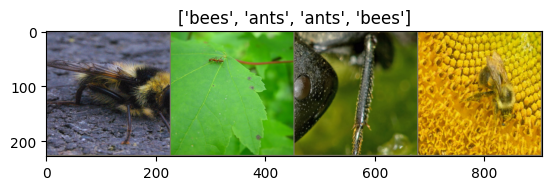

In [5]:
def show_img(input, title=None):

  input = input.numpy().transpose((1, 2, 0))

  mean = np.array([0.485, 0.456, 0.406])

  std = np.array([0.229, 0.224, 0.225])

  input = std * input + mean

  input = np.clip(input, 0, 1)

  plt.imshow(input)

  if title is not None:
    plt.title(title)

input, classess = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(input)

show_img(out, title=[classes[x] for x in classess])

In [6]:
import time
def train_model(model,criterion, optimizer, sheduler, num_epochs=25):

  since_time = time.time()

  with TemporaryDirectory() as tmpdir:

    best_model_params_path = os.path.join(tmpdir, 'best_params.pt')

    torch.save(model.state_dict(), best_model_params_path)

    best_accuracy = 0.0

    for epochs in range(num_epochs):

      print(f"Epochs[{epochs} / {num_epochs - 1}]")

      for phase in ['train', 'val']:

        if phase == 'train':
          model.train()

        else:
          model.eval()

        running_loss = 0.0
        running_correct = 0.0

        for input, labels in dataloaders[phase]:
          input = input.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(phase=='train'):
            out = model(input)
            _, predict = torch.max(out, 1)
            loss = criterion(out, labels)

            if phase == 'train':

              loss.backward()
              optimizer.step()

          running_loss += loss.item() * input.size(0)
          running_correct += torch.sum(predict == labels.data)

        if phase == 'train':
          sheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_accuracy = running_correct.double() / dataset_sizes[phase]
        print(f"Accuracy: {epoch_accuracy}   Loss: {epoch_loss}")
        print()

        if epoch_accuracy > best_accuracy and phase == 'val':
          best_accuracy = epoch_accuracy
          torch.save(model.state_dict(), best_model_params_path)
    end = time.time() - since_time

    print(f'Train end with {end // 60} with best accuracy: {best_accuracy}')

    model.load_state_dict(torch.load(best_model_params_path))
    return model



In [7]:
!pip install torchinfo

In [8]:
from torchinfo import summary

summary(model=models.resnet18(weights='IMAGENET1K_V1'), input_size=(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.4MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [9]:
models.resnet18(weights='IMAGENET1K_V1')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model_fn = models.resnet18(weights='IMAGENET1K_V1')
#fc with (fc): Linear(in_features=512, out_features=1000, bias=True) we need 2 classes
num_feat = model_fn.fc.in_features

model_fn.fc = nn.Linear(num_feat, 2)

model_fn = model_fn.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_fn.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [12]:
model_ft = train_model(model_fn, criterion, optimizer, exp_lr_scheduler)

Epochs[0 / 24]
Accuracy: 0.6844262295081968   Loss: 0.6954564116284495

Accuracy: 0.8758169934640523   Loss: 0.26582958359344333

Epochs[1 / 24]
Accuracy: 0.7663934426229508   Loss: 0.48676412373964417

Accuracy: 0.8954248366013072   Loss: 0.3091464088438383

Epochs[2 / 24]
Accuracy: 0.7377049180327869   Loss: 0.6402857463623657

Accuracy: 0.738562091503268   Loss: 0.6495868630029696

Epochs[3 / 24]
Accuracy: 0.8401639344262295   Loss: 0.43685223643103094

Accuracy: 0.9215686274509804   Loss: 0.191502653204629

Epochs[4 / 24]
Accuracy: 0.8442622950819673   Loss: 0.39250973357101443

Accuracy: 0.8758169934640523   Loss: 0.33576613107659653

Epochs[5 / 24]
Accuracy: 0.8032786885245902   Loss: 0.453481531701982

Accuracy: 0.869281045751634   Loss: 0.28520816160378115

Epochs[6 / 24]
Accuracy: 0.7827868852459017   Loss: 0.5414912137737284

Accuracy: 0.8104575163398693   Loss: 0.5172751149059169

Epochs[7 / 24]
Accuracy: 0.8278688524590164   Loss: 0.3356447939257153

Accuracy: 0.88235294117

<ipython-input-6-8cdb3e61f588>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [42]:

# def visualize_model_predictions(model,img_path):
#     was_training = model.training
#     model.eval()

#     img = Image.open(img_path)
#     img = data_transform['val'](img)
#     img = img.unsqueeze(0)
#     img = img.to(device)

#     with torch.no_grad():
#         outputs = model(img)
#         _, predict = torch.max(outputs, 1)

#         ax = plt.subplot(2,2,1)
#         ax.axis('off')
#         ax.set_title(f'Predicted: {classes[predict[0]]}')
#         plt.imshow(img.cpu().data[0].numpy().transpose(1, 2, 0))

#         model.train(mode=was_training)

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transform['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {classes[preds[0]]}')
        plt.imshow(img.cpu().data[0].numpy().transpose(1, 2, 0))

        model.train(mode=was_training)

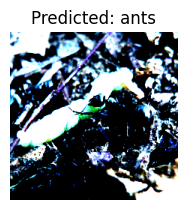

In [43]:
visualize_model_predictions(
    model_ft, '/content/hymenoptera_data/val/ants/1119630822_cd325ea21a.jpg'
)
plt.ioff()
plt.show()